In [1]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math 
from load_matlab_timedata import get_data_from
import sklearn.preprocessing 
from tqdm import tqdm_notebook as tqdm
import random
import yaml
import h5py
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler
import logging
import datetime
import os
import time
import torch.nn.functional as F
from src.TSGenerator import f_Y, f_X, get_func_timeseries
from src.DataLoader import TimeSeriesDataset
from src.model_utils import init_logger, plot_shared_scale, plot_multiscale
from src.Model import LSTM
from src.Losses import myLoss, prognose_dy
import pprint

In [2]:
! ls DC_motor_simulation

dc_engine_random_sig_const_periods.slx
dc_engine_random_sig_random_period_gaus_noise.slx
dc_engine_random_sig_random_period_gaus_noise.slx.autosave
dc_engine_random_sig_random_period_gaus_noise.slxc
dc_engine_random_sig_random_period.slx
dc_engine_random_sig_random_period.slxc
dc_engine_random_sig_random_period.slx.original
DC_motor_simulation.prj
diff_eq_system.slx
diff_eq_system.slx.original
res.mat
resources
slprj


In [3]:
plt.rcParams['figure.figsize'] = 20, 7.

In [4]:
CONFIG_FILENAME = "model_params.yaml"

In [5]:
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
to_generate_data = config['to_generate_data']
if to_generate_data:
    p_gen = config['generator_params']
    a = p_gen['a']
is_debug = config['is_debug']
if is_debug:
    p_generate = config['generator_params']
    pprint.pprint(p_generate)
    

In [7]:
pprint.pprint(config)

{'data_params': {'leave_nth': 13,
                 'mat_file': 'DC_motor_simulation/res.mat',
                 'need_normalize': True,
                 'test_size': 0.3},
 'exp_path': 'only_batches',
 'generator_params': {'a': 0.5, 'b': 1.0, 'f_X': 'math.sin', 'f_Y': 'math.cos'},
 'is_debug': False,
 'network_params': {'dtype': 'torch.float',
                    'hidden_size': 16,
                    'input_size': 64,
                    'num_layers': 2,
                    'output_dim': 3,
                    'per_element': True,
                    'retrospective_steps': 128},
 'to_generate_data': False,
 'train_params': {'batch_size': 256,
                  'learning_rate': 0.001,
                  'loss_fn': 'mse',
                  'num_epochs': 30,
                  'optimizer': 'adam',
                  'reduction': 'sum'}}


In [8]:
p_data = config['data_params']
pprint.pprint(p_data)
need_normalize = p_data['need_normalize']

{'leave_nth': 13,
 'mat_file': 'DC_motor_simulation/res.mat',
 'need_normalize': True,
 'test_size': 0.3}


In [9]:
p_net = config['network_params']
pprint.pprint(p_net)

{'dtype': 'torch.float',
 'hidden_size': 16,
 'input_size': 64,
 'num_layers': 2,
 'output_dim': 3,
 'per_element': True,
 'retrospective_steps': 128}


In [10]:
p_train = config['train_params']
pprint.pprint(p_train)

{'batch_size': 256,
 'learning_rate': 0.001,
 'loss_fn': 'mse',
 'num_epochs': 30,
 'optimizer': 'adam',
 'reduction': 'sum'}


In [11]:
p_gen = config['generator_params']
a = p_gen['a']
b = p_gen['b']

In [12]:
if is_debug:
    x, y = get_func_timeseries(f_Y = f_Y, f_X = f_X, a=p_generate['a'], b=p_generate['b'])

In [13]:
#####################
# Set parameters
#####################
# # If `per_element` is True, then LSTM reads in one timestep at a time.
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']

In [14]:
init_logger(config)

logger inited to file [only_batcheslogs/exp_2019-04-27_01:37:43.log]


In [15]:
logging.info("Experiment started with params")
logging.info(f"data_par: {p_data}")
logging.info(f"net_par: {p_net}")
logging.info(f"train_par: {p_train}")

X normalized, norms: [14.99712541]
x shaoe (76924,)
x_normalized shaoe (76924, 1)
test (76924, 1)


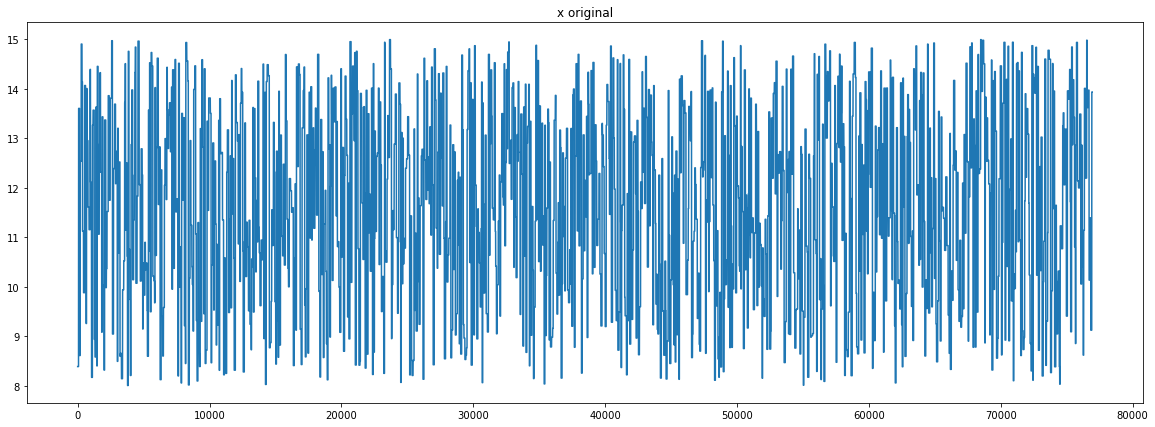

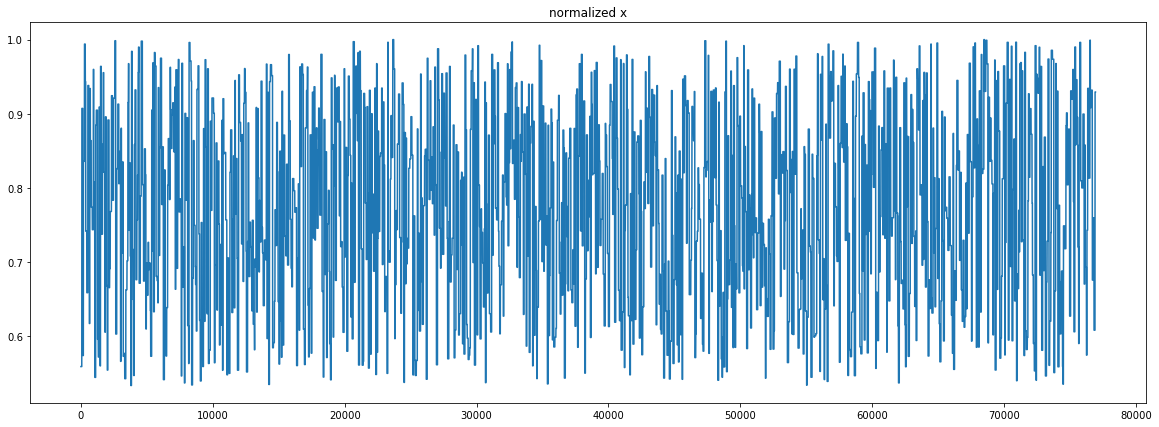

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (4615, 1)
output partition shape (4615, 1)
stacked Y shape  (4487, 3)
Y_tensor torch.Size([4487, 3])
X_tensor torch.Size([128, 4486, 1])


In [16]:
test_ts_ds = TimeSeriesDataset(config=config,
                               partition=(0.2 - 0.2*p_data['test_size'], 0.2),                        
                               logging=logging)

X normalized, norms: [14.99712541]
x shaoe (76924,)
x_normalized shaoe (76924, 1)
test (76924, 1)


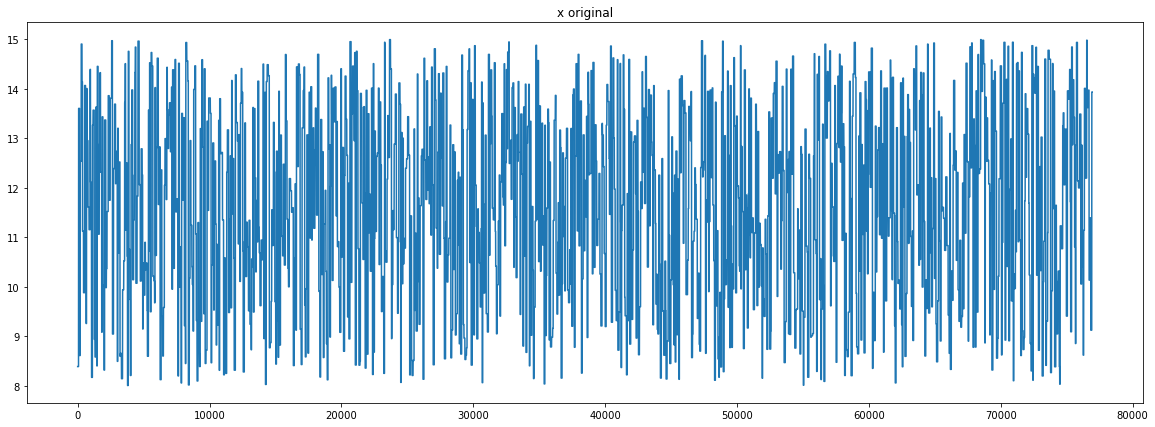

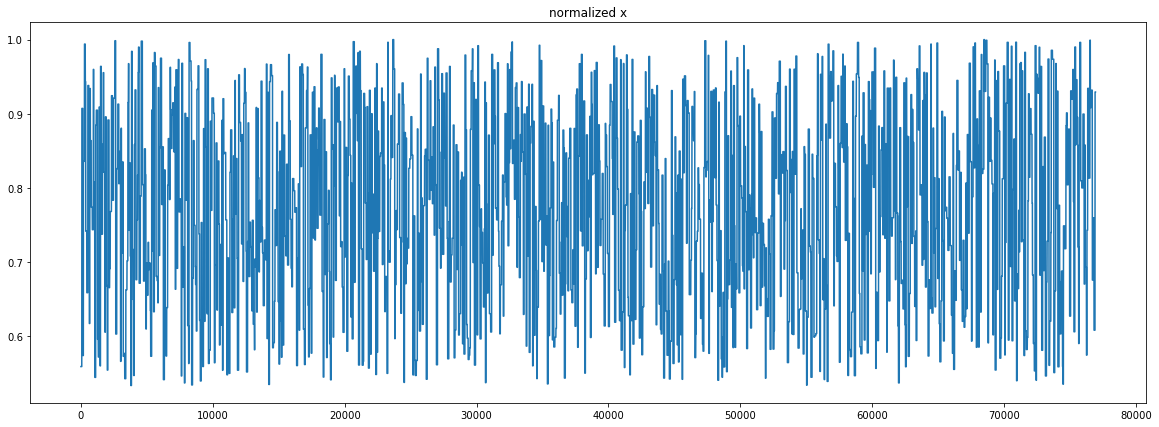

Y normalized, norms: [0.01499693]
input shape (76924, 1)
input partition shape (10769, 1)
output partition shape (10769, 1)
stacked Y shape  (10641, 3)
Y_tensor torch.Size([10641, 3])
X_tensor torch.Size([128, 10640, 1])


In [17]:
train_ts_ds = TimeSeriesDataset(config=config,
                                partition=(0, 0.2 - 0.2*p_data['test_size']),
                                logging=logging)

In [18]:
if need_normalize:
    config['x_norm'] = train_ts_ds.x_norms
    config['y_norm'] = train_ts_ds.y_norms
    config['x_norm']
else:
    config['x_norm'] = 1
    config['y_norm'] = 1
    config['x_norm']

In [19]:
train_dl = DataLoader(dataset = train_ts_ds,
                      batch_sampler = BatchSampler(
                          sampler = SequentialSampler(train_ts_ds), 
                          batch_size = p_train['batch_size'],
                          drop_last = True)
                     )
test_dl = DataLoader(dataset = test_ts_ds,
                     batch_sampler = BatchSampler(
                     sampler = SequentialSampler(test_ts_ds), 
                     batch_size = p_train['batch_size'], 
                     drop_last = True)
                    )

In [20]:
## Inspecting data we have

In [21]:
len(train_dl)

41

x :torch.Size([256, 128, 1])
y: torch.Size([256, 3])
y_last: (150,)


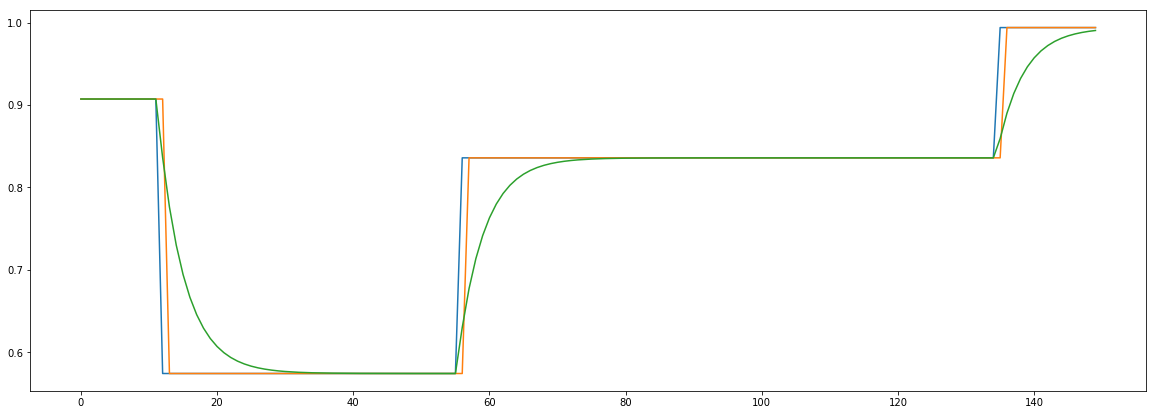

x :torch.Size([256, 128, 1])
y: torch.Size([256, 3])
y_last: (150,)


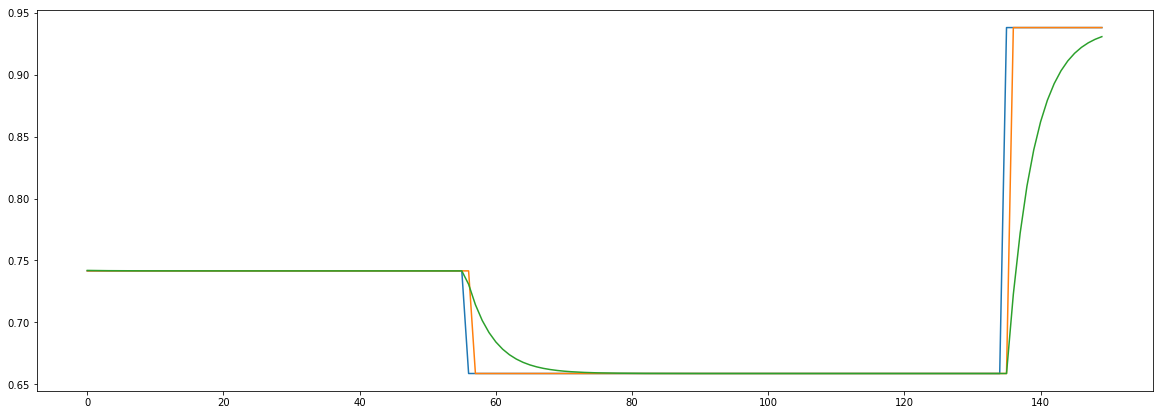

In [22]:
f, t = 0, 150
for i, batch in enumerate(train_dl):
    x, y, ind = batch
    print(f"x :{x.shape}")
    print(f"y: {y.shape}")
    y_kth = y.detach().numpy()[f:t, 0]
    print(f"y_last: {y_kth.shape}")
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-1][f:t])
    plt.plot(x.detach().numpy()[-2][f:t])
    plt.plot(y_kth)
    plt.show()
    if i == 1:
        break

In [23]:
model = LSTM(lstm_input_size,
             p_net['hidden_size'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

loss_fn = myLoss

# if p_train['loss_fn'] == 'mse':  
#     loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
# elif p_train['loss_fn'] == 'l1':  
#     loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

if p_train['optimizer'] == "adam":
    optimiser = torch.optim.Adam(model.parameters(), lr=p_train['learning_rate'])

In [24]:
logging.info(f"Model n params: {model.get_num_params()}")

In [25]:
model.get_num_params()

3443.0

In [26]:
len(train_dl)

41

In [27]:
num_epochs = p_train['num_epochs']

In [28]:
logging.info("Training process START")

In [29]:
# #####################
# # Train model
# #####################
# from torch.nn import init
# for layer_p in a._all_weights:
#     for p in layer_p:
#         if 'weight' in p:
#             # print(p, a.__getattr__(p))
#             init.normal(a.__getattr__(p), 0.0, 0.02)

In [30]:
hist = {"train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        
        "aux":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        },
        
        "const":{
            "train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs),
        },
        'preds':{
            '1':np.zeros(num_epochs),
            '2':np.zeros(num_epochs),            
        }
       }

In [31]:
parameters_values = {
    'p1' : np.arange(-3.0, 3.0, .2),
#     'p2' : np.arange(-3.0, 2.0, .2)
}
# parameters_values['p2']*=0
# parameters_values['p2']+=1

search_space_shape = [dim.size for dim in parameters_values.values()]
loss_values = np.zeros(search_space_shape)

-3.0


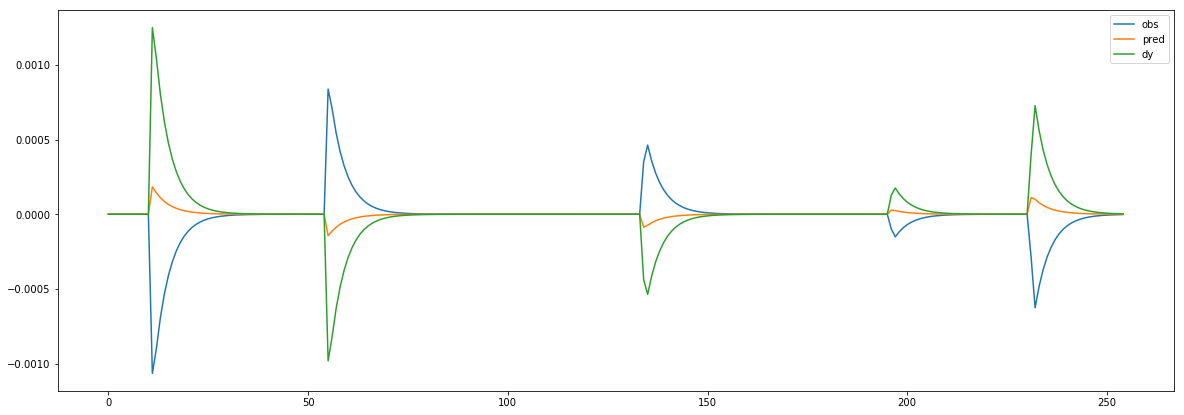

-2.8


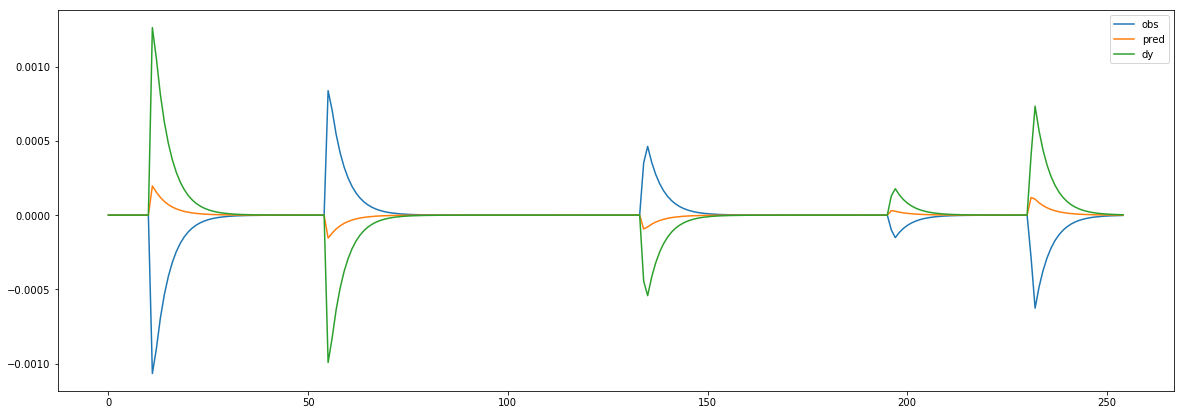

-2.5999999999999996


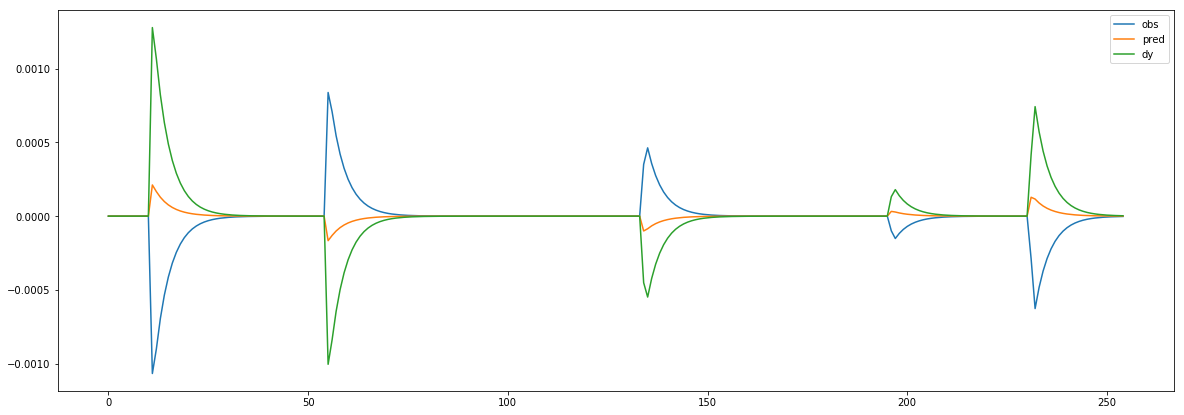

-2.3999999999999995


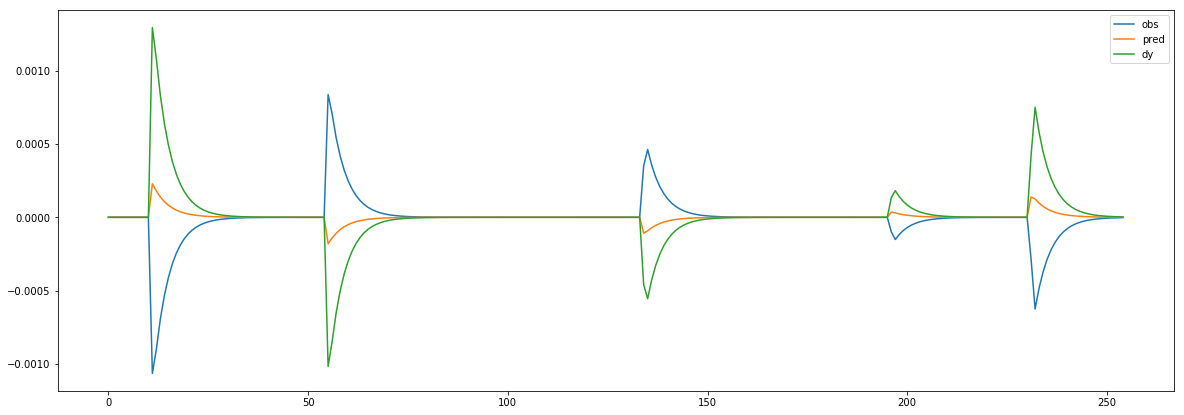

-2.1999999999999993


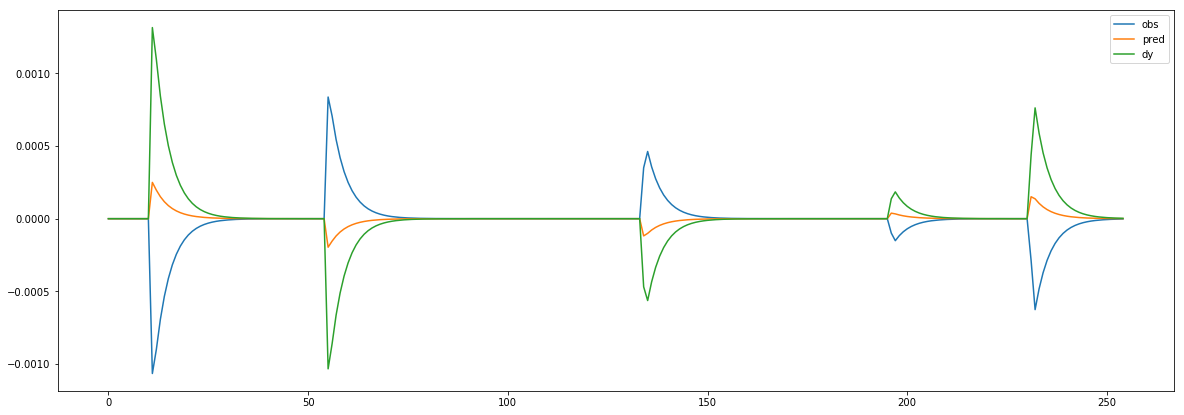

-1.9999999999999991


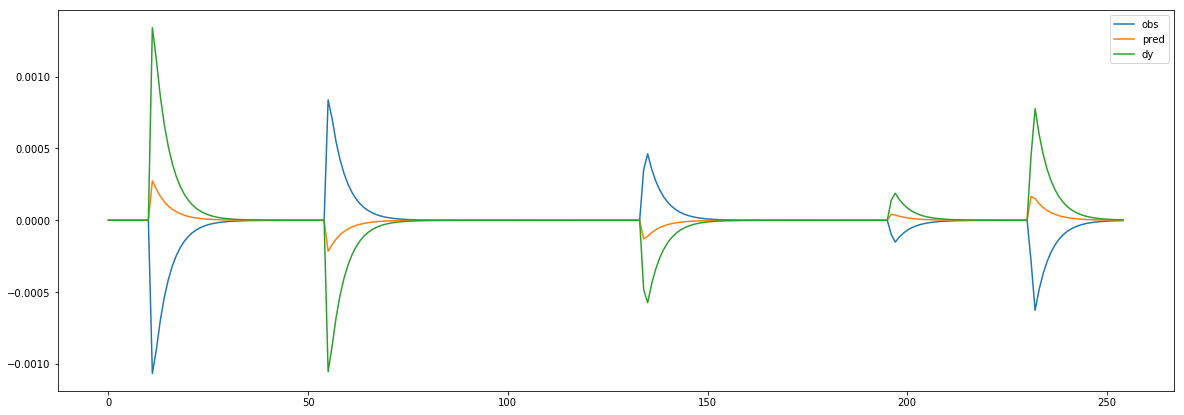

-1.799999999999999


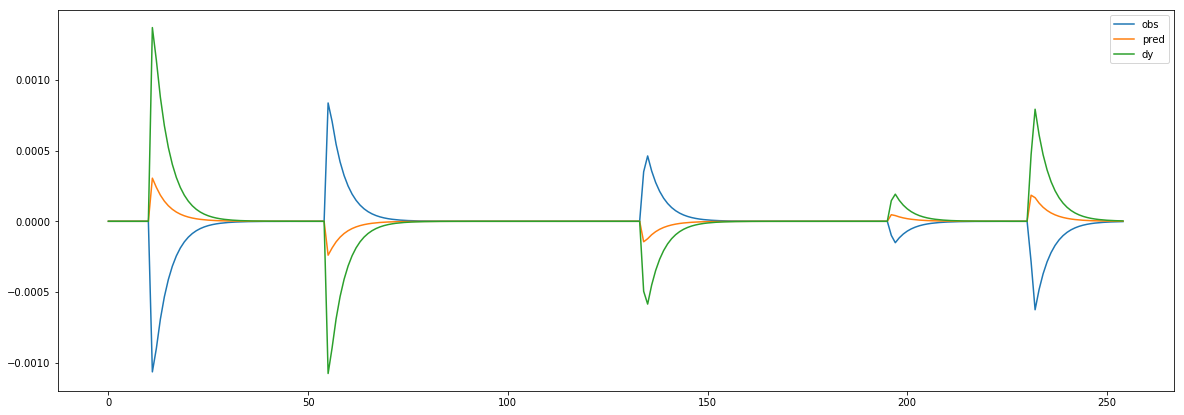

-1.5999999999999988


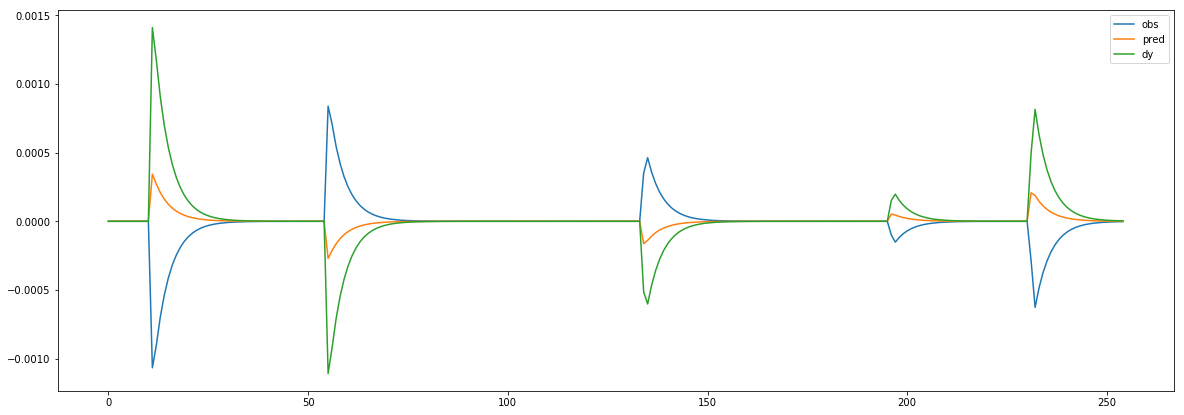

-1.3999999999999986


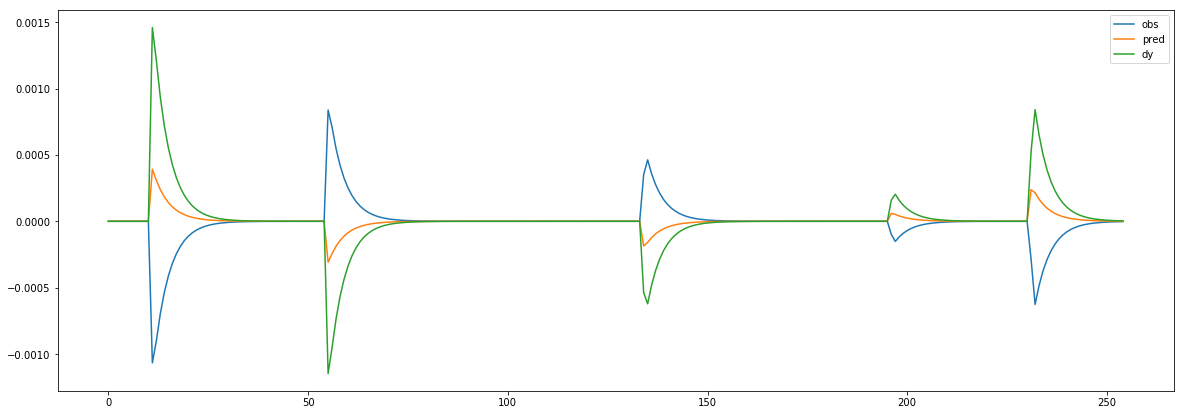

-1.1999999999999984


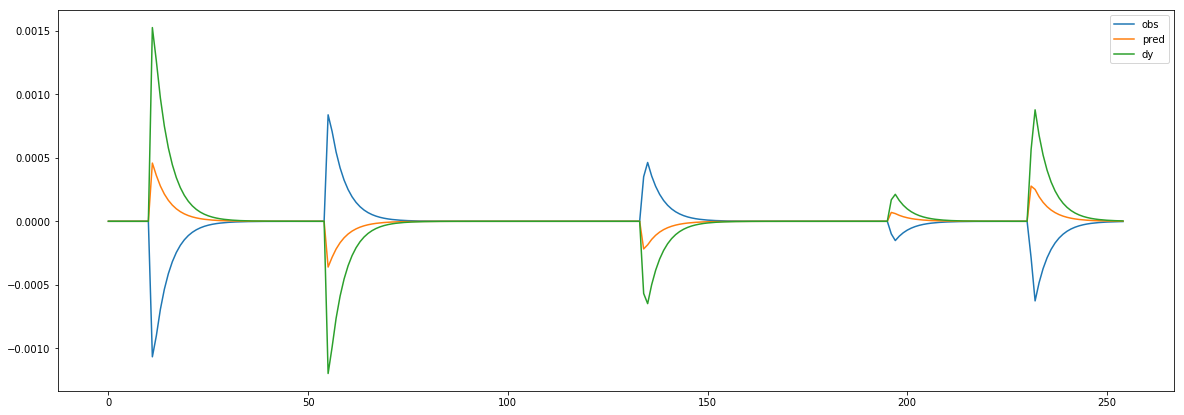

-0.9999999999999982


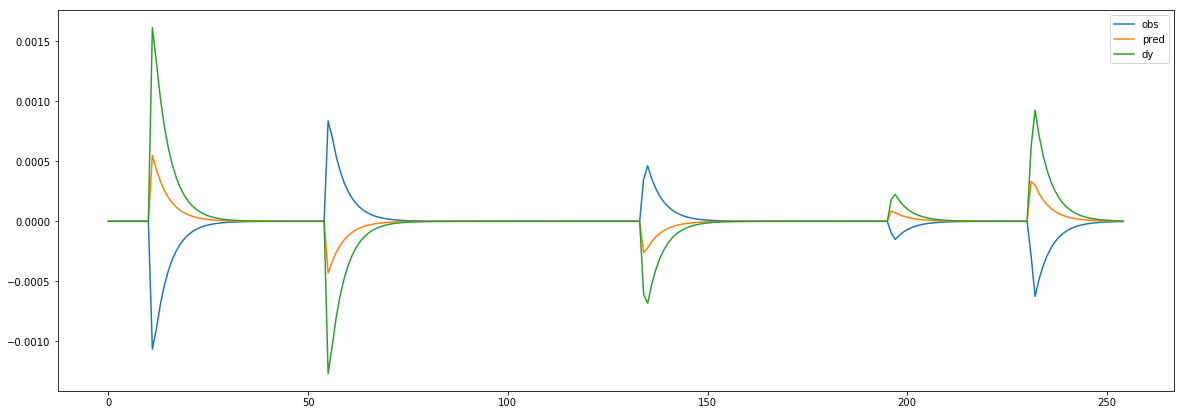

-0.799999999999998


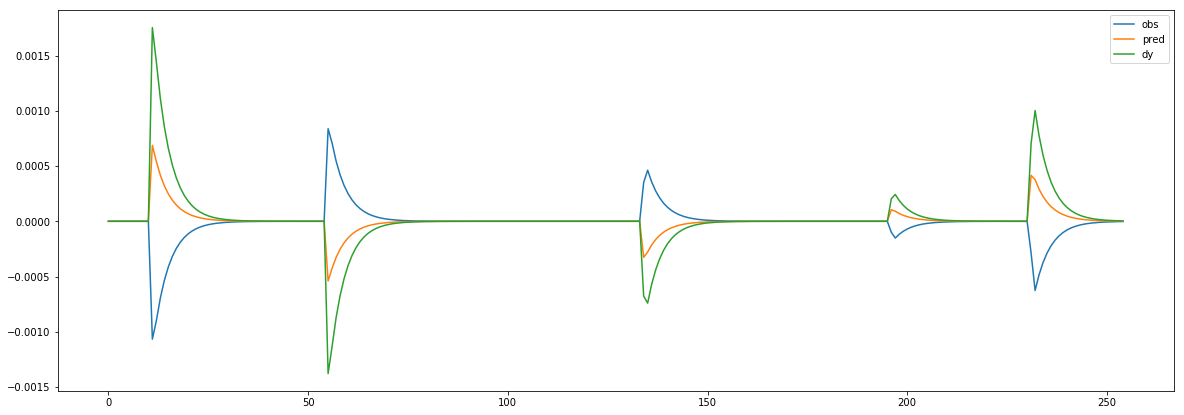

-0.5999999999999979


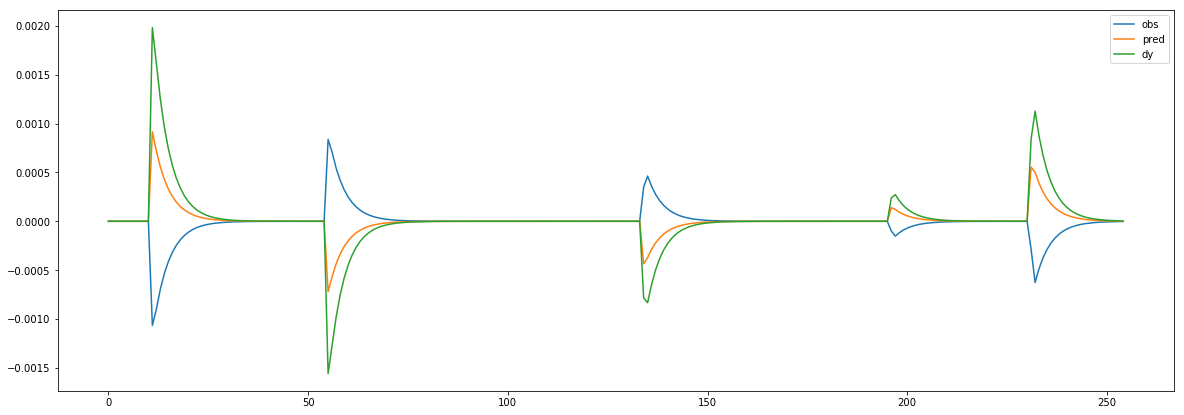

-0.3999999999999977


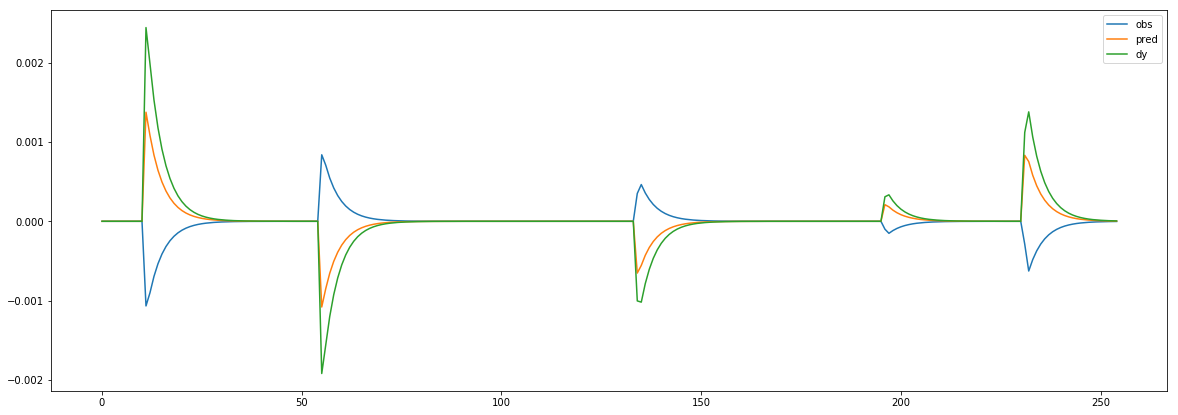

-0.1999999999999975


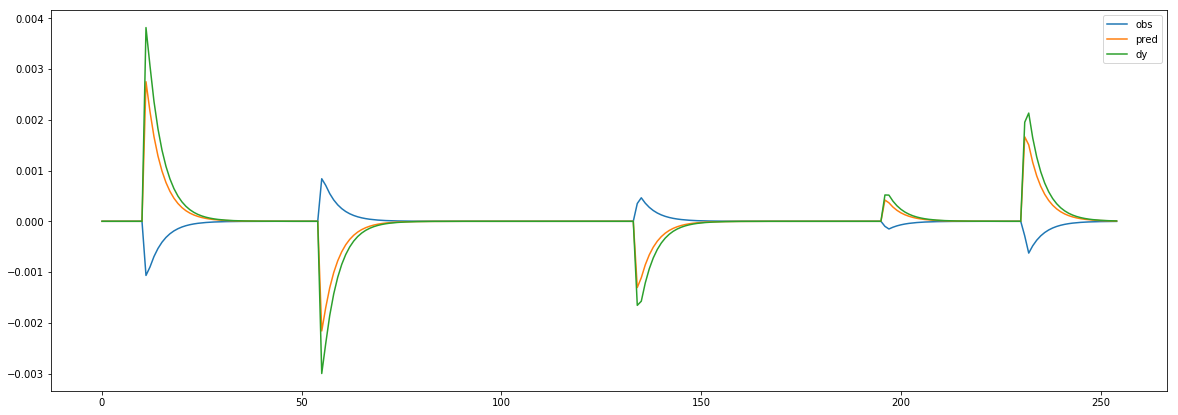

2.6645352591003757e-15


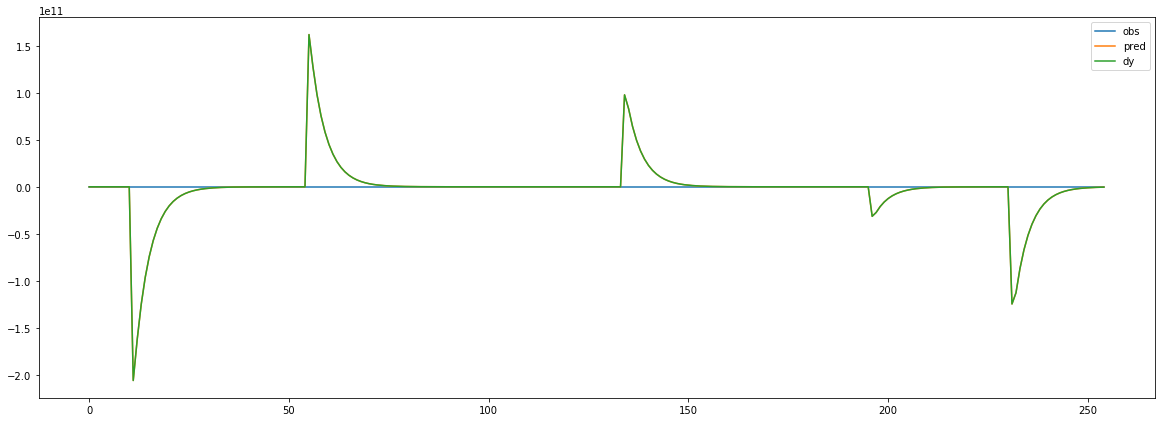

0.20000000000000284


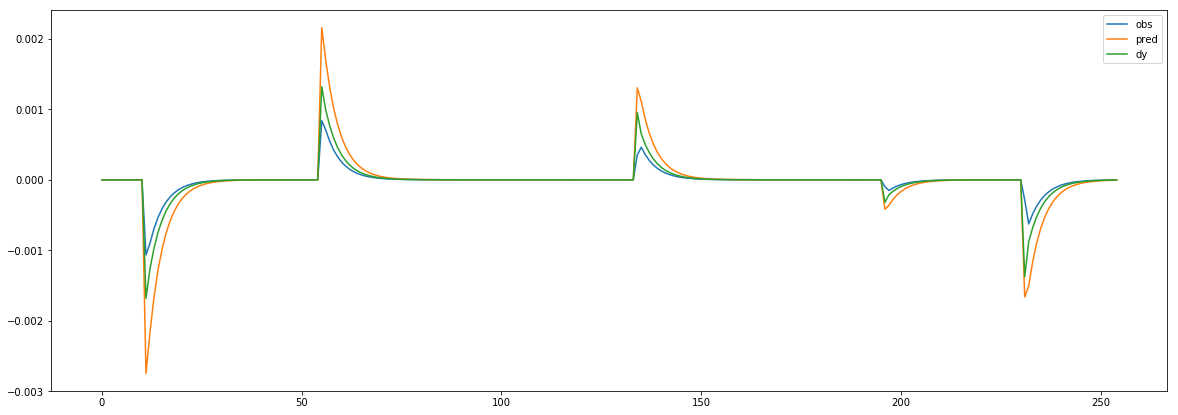

0.400000000000003


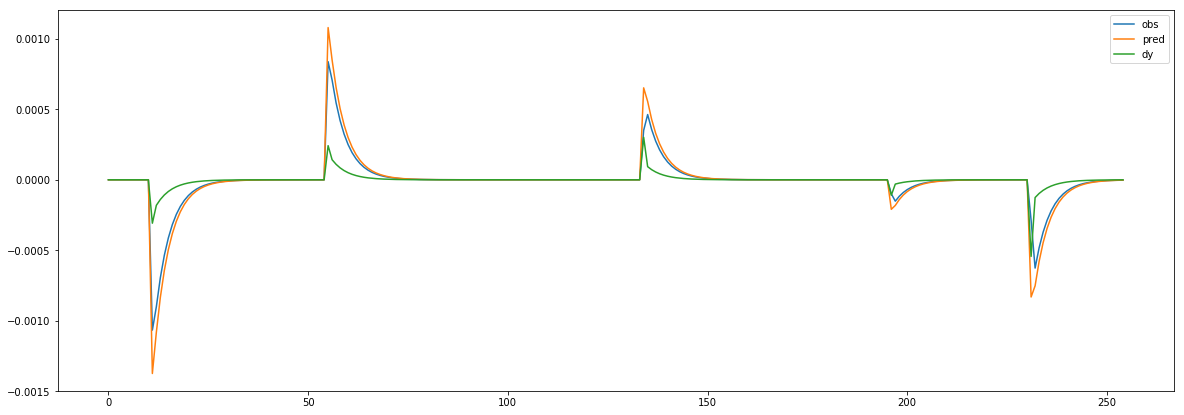

0.6000000000000032


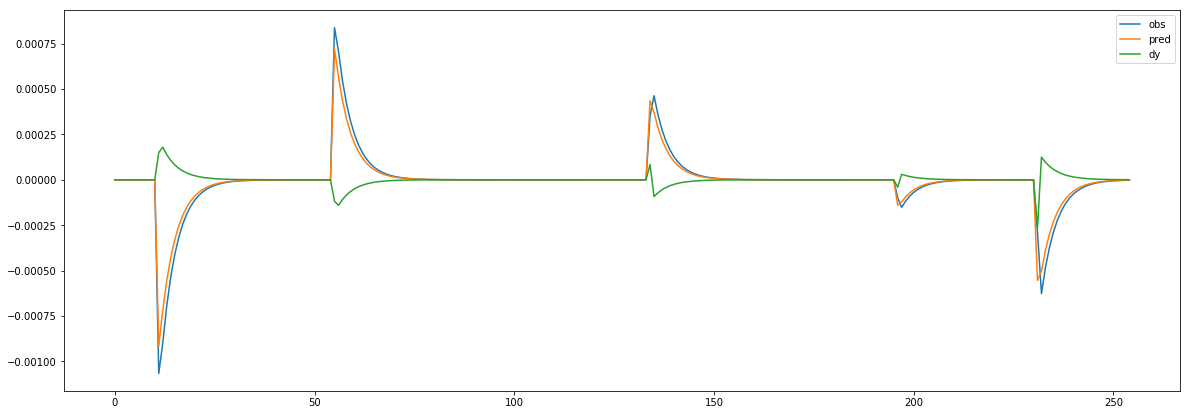

0.8000000000000034


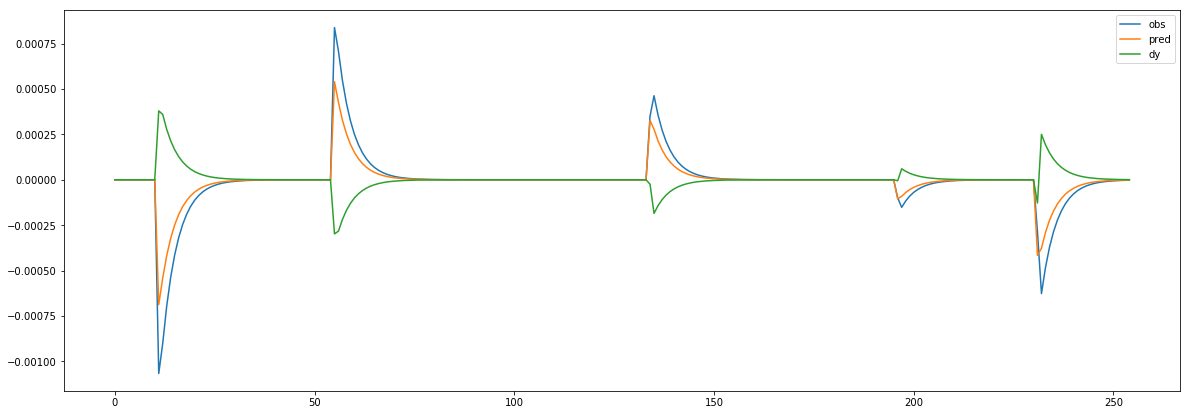

1.0000000000000036


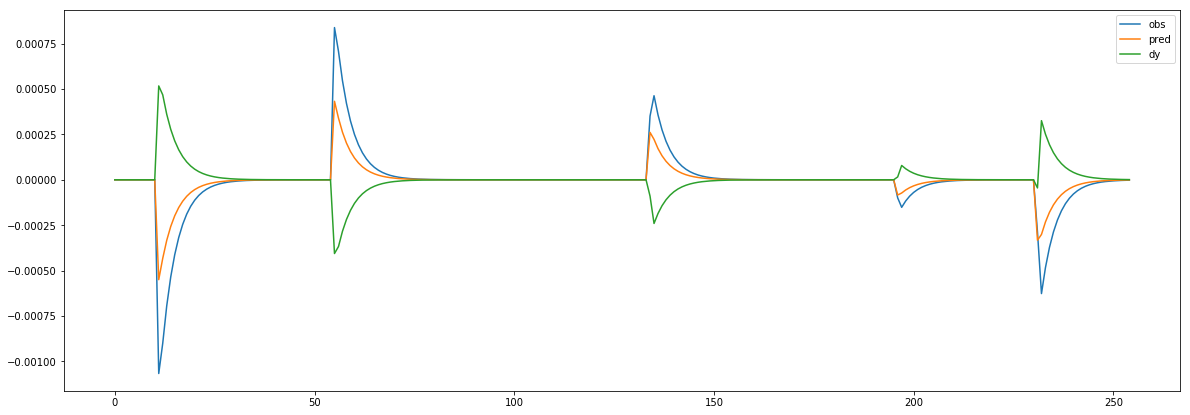

1.2000000000000037


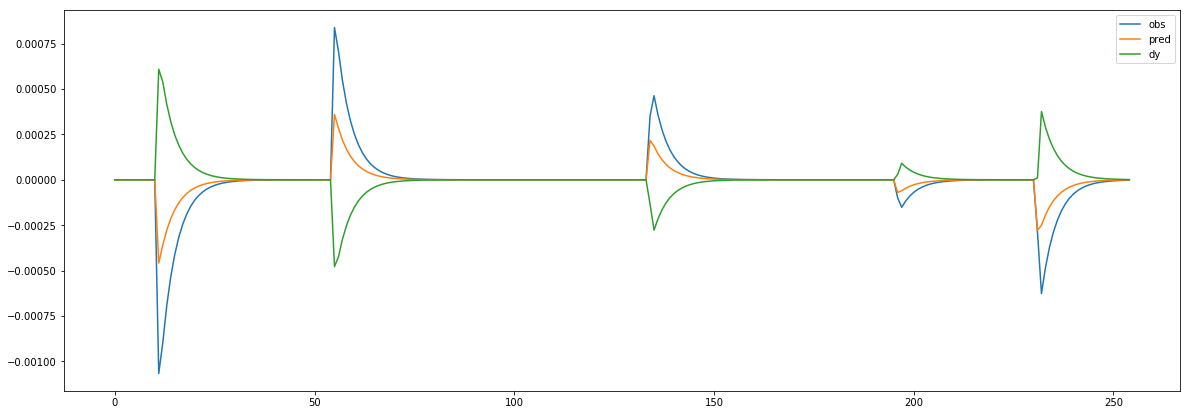

1.400000000000004


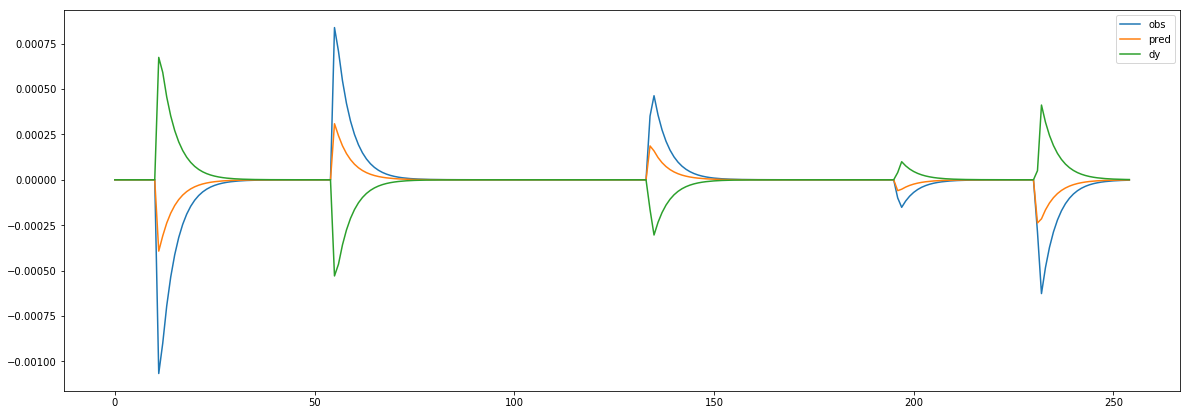

1.600000000000004


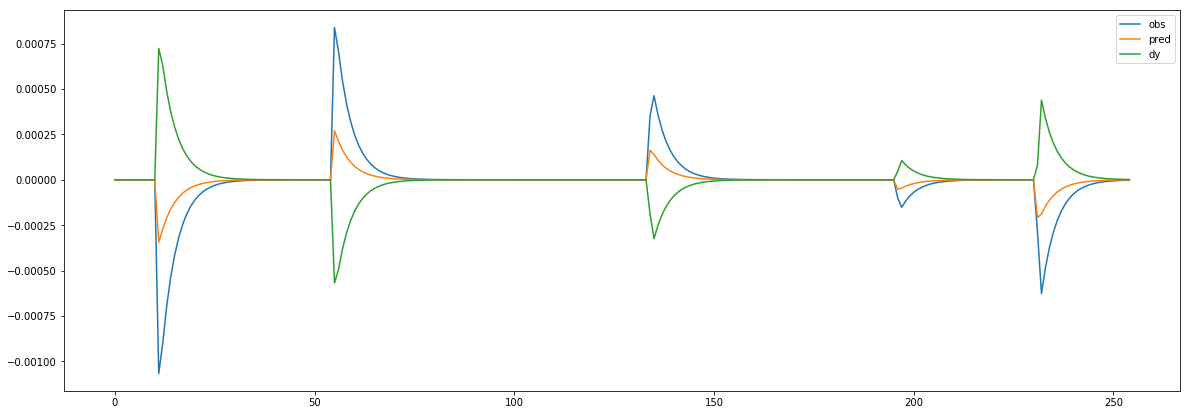

1.8000000000000043


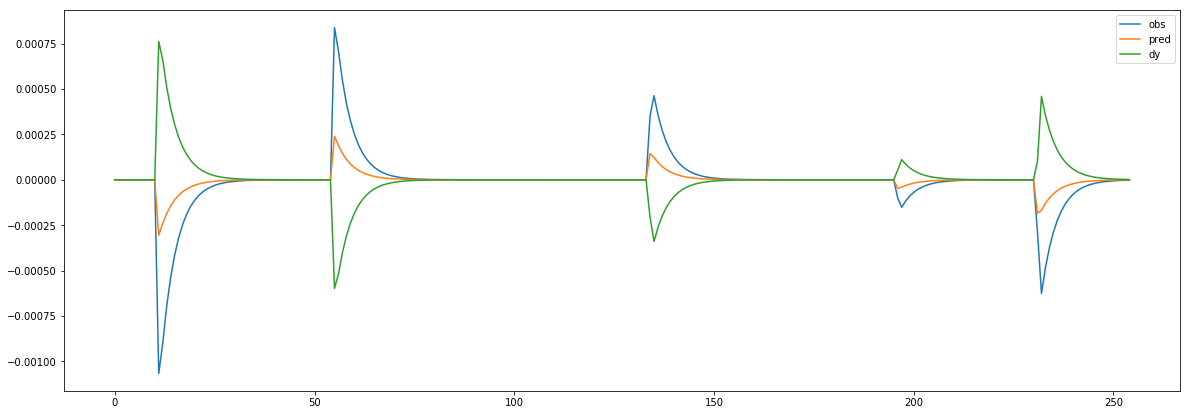

2.0000000000000044


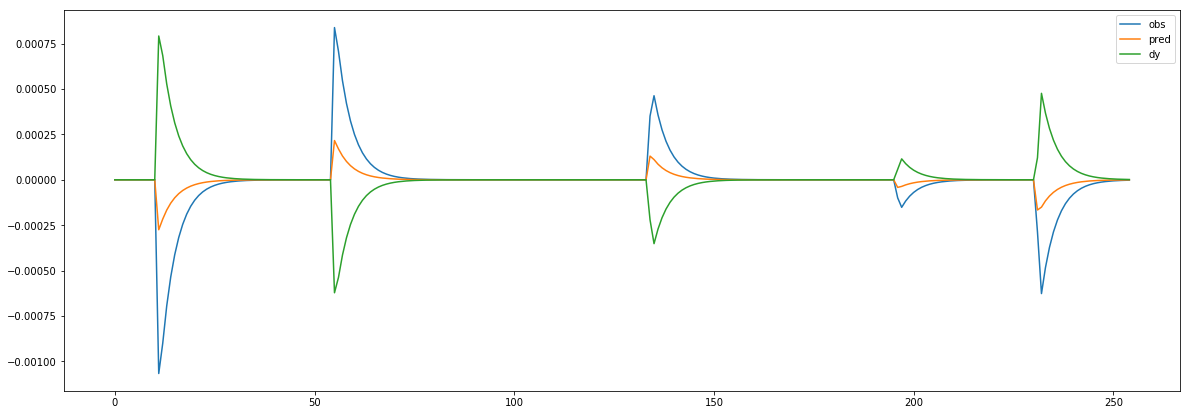

2.2000000000000046


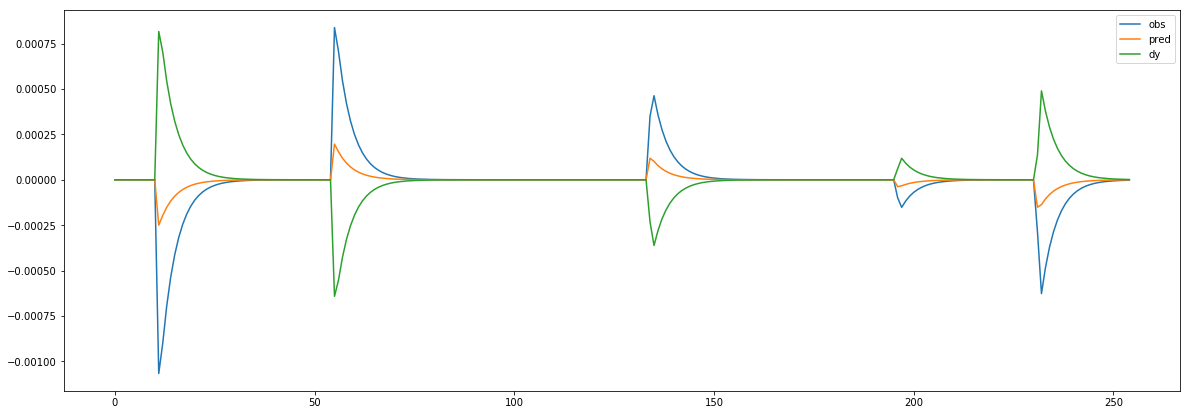

2.400000000000005


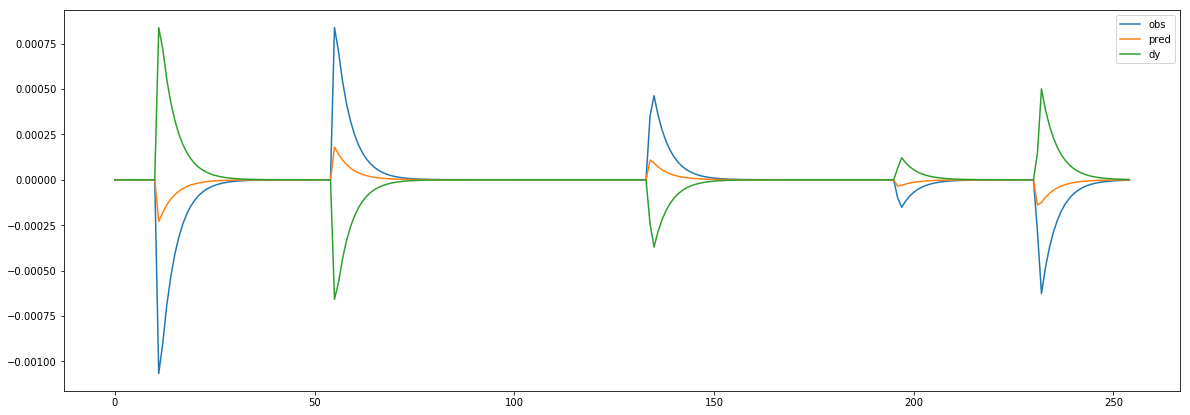

2.600000000000005


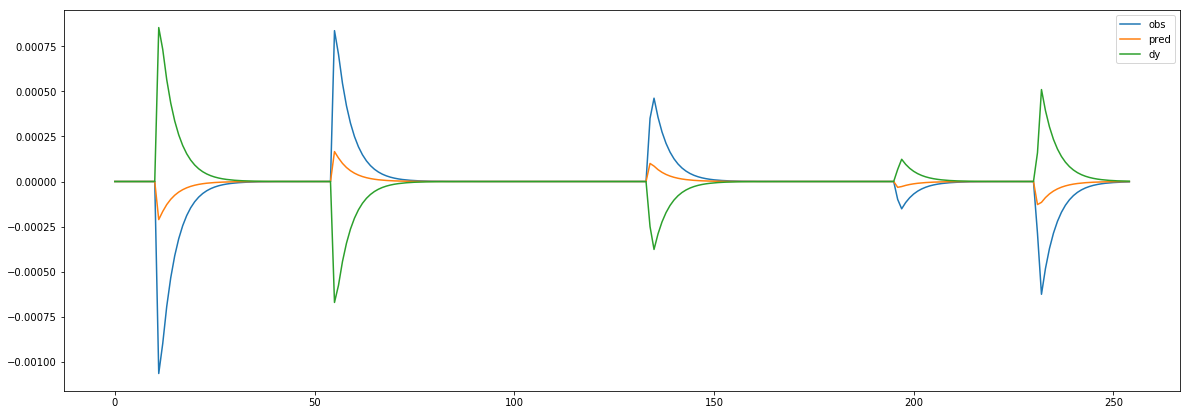

2.800000000000005


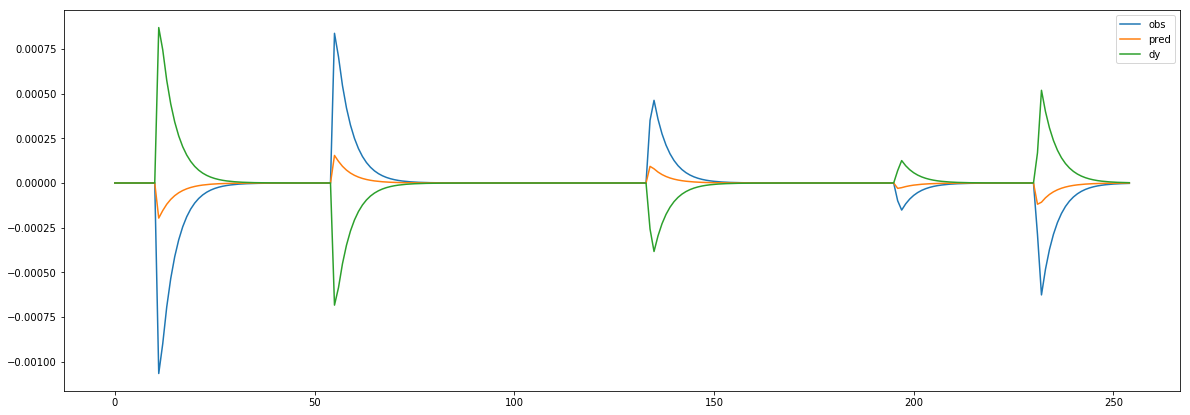

In [32]:


model.hidden = model.init_hidden()
for i_p1, p1 in enumerate(tqdm(parameters_values['p1'])):
#     print(i_p1)
#     for i_p2, p2 in enumerate(parameters_values['p2']):

#     for t in range(num_epochs):
#             print(i_p2)
    for i, data in enumerate(train_dl):
        x_batch, y_batch, indexes = data
        x_batch.transpose_(0, 1)
        model.hidden = model.init_hidden()


    # Forward pass
#                 y_pred = model(x_batch)
        y_batch[:,1] *= 0
        y_batch[:,1] += p1

        y_batch[:,2] *= 0
        y_batch[:,2] += 1


        loss = loss_fn(y_batch, y_batch, x_batch, config)
        main_loss, aux_loss, const_loss, y_obs, y_pred, dy = loss
        print(p1.item())
        plot_shared_scale([
            (y_obs.detach().numpy(), "obs"),
            (y_pred.detach().numpy(), "pred"),
            (dy.detach().numpy(), "dy"),
            
        ])
        combined_loss = main_loss + aux_loss + const_loss

        loss_values[i_p1]=combined_loss.item()
        break
#     break

#                 optimiser.zero_grad()
#                 combined_loss.backward()
#                 optimiser.step()


#                 hist['train_local_loss'][i] = combined_loss.item()
#                 hist['const']['train_local_loss'][i] = const_loss.item()
#                 hist['aux']['train_local_loss'][i] = aux_loss.item() #torch.mean(torch.abs(y_pred[:, 1] - a))



#             hist['preds']['1'][t] =torch.mean(y_pred[:, 1]) 
#             hist['preds']['2'][t] =torch.mean(y_pred[:, 2]) 

#             print(f"aux preds: {torch.mean(y_pred[:, 1])} {torch.mean(y_pred[:, 2])}")
#             print(f"aux loss {np.average(hist['aux']['train_local_loss'])}")
#             print(f"combined loss {np.average(hist['train_local_loss'])}")

#             plot_shared_scale([
#                 (y_pred[:, 0].detach().numpy(),"Preds" ),
#                  (y_batch[:, 0].detach().numpy(), "Data"),
#                  (x_batch[-1].detach().numpy(), "Input")
#                 ])

#             residuals = y_batch[:, 0] - y_pred[:, 0]

#             plot_multiscale([
#                 (residuals.detach().numpy(), "Red"),
#                 (y_batch[:, 0].detach().numpy(), "Green")
#             ]) 


#                   # validate during evaluation
#             with torch.no_grad():
#                 model = model.eval()
#                 for i, data in enumerate(tqdm(train_dl)):
#                     x_batch, y_batch, indexes = data
#                     x_batch.transpose_(0, 1)
#                     y_pred = model(x_batch)
#                     loss = loss_fn(y_pred, y_batch, x_batch, config)
#                     main_loss, aux_loss, const_loss = loss

#                     hist['eval_train_local'][i] = main_loss.item()
#                     hist['const']['eval_train_local'][i] = const_loss.item()
#                     hist['aux']['eval_train_local'][i] = aux_loss.item()#torch.mean(torch.abs(y_pred[:, 1] - a) )
#                 for i, data in enumerate(tqdm(test_dl)):
#                     x_batch_test, y_batch_test, indexes = data
#                     x_batch_test.transpose_(0, 1)
#                     y_pred_test = model(x_batch_test)
#                     loss = loss_fn(y_pred_test, y_batch_test, x_batch_test, config)
#                     main_loss, aux_loss, const_loss = loss
#                     hist['const']['eval_test_local'][i] = const_loss.item()
#                     hist['eval_test_local'][i] = main_loss.item()
#                     hist['aux']['eval_test_local'][i] = aux_loss.item()#torch.mean(torch.abs(y_pred_test[:, 1] - a) )
#                 model = model.train()


#             print("TEST AUX:")
#             plot_shared_scale([
#                     (y_pred_test[:, 1].detach().numpy(),"par_1" ),
#                     (y_pred_test[:, 2].detach().numpy(),"par_2" ),
#             ])

#             print("TEST PRED:")
#             plot_shared_scale([
#                     (y_pred_test[:, 0].detach().numpy(),"Preds" ),
#                      (y_batch_test[:, 0].detach().numpy(), "Data"),
#                      (x_batch_test[-1].detach().numpy(), "Input")
#             ])


#             residuals = y_batch_test[:, 0] - y_pred_test[:, 0]
#             print("TEST RESID:")
#             plot_multiscale(
#                     [
#                         (residuals.detach().numpy(), "Red"), 
#                      (y_batch_test[:, 0].detach().numpy(),"Green")
#                     ])


#             logging.info(f"Epoch [{t}] \
#             \n train_loss[{hist['train_loss'][t]}] \
#             \n eval_traiDn[{hist['eval_train'][t]}] \
#             \n eval_test[{hist['eval_test'][t]}] ")


#             hist["train_loss"][t] = np.average(hist["train_local_loss"])
#             hist["eval_train"][t] = np.average(hist["eval_train_local"])
#             hist["eval_test"][t] = np.average(hist["eval_test_local"])
#             hist['aux']['eval_test'][t] = np.average(hist['aux']['eval_test_local'])
#             hist['aux']['eval_train'][t] = np.average(hist['aux']['eval_train_local'])
#             hist['aux']['train_loss'][t] = np.average(hist['aux']['train_local_loss'])
#             hist['const']['eval_test'][t] = np.average(hist['const']['eval_test_local'])
#             hist['const']['eval_train'][t] = np.average(hist['const']['eval_train_local'])
#             hist['const']['train_loss'][t] = np.average(hist['const']['train_local_loss'])

#         #     hist["aux_error"][t] = np.average[]
#             print(f" Epoch [{t}] \
#             \n train_loss[{hist['train_loss'][t]}] \
#             \n eval_train[{hist['eval_train'][t]}] \
#             \n eval_test[{hist['eval_test'][t]}] ")
#             logging.info(f" Epoch [{t}] \
#             \n train_loss[{hist['train_loss'][t]}] \
#             \n eval_train[{hist['eval_train'][t]}] \
#             \n eval_test[{hist['eval_test'][t]}] ")

In [33]:
loss_values

array([3010.        , 2809.99291992, 2609.99755859, 2410.00048828,
       2210.00561523, 2010.        , 1809.99572754, 1610.00378418,
       1409.99645996, 1210.00024414, 1010.        ,  810.00189209,
        610.00012207,  410.00094604,  210.00048828,   10.        ,
         -3.76851058,   -5.51951981,   -5.76442003,   -5.14976454,
         -4.88867235,   -4.74289942,   -4.64374113,   -4.5753336 ,
         -4.52518606,   -4.48680115,   -4.45645809,   -4.43185472,
         -4.41150093,   -4.3943758 ])

In [ ]:
while(True):
    pass

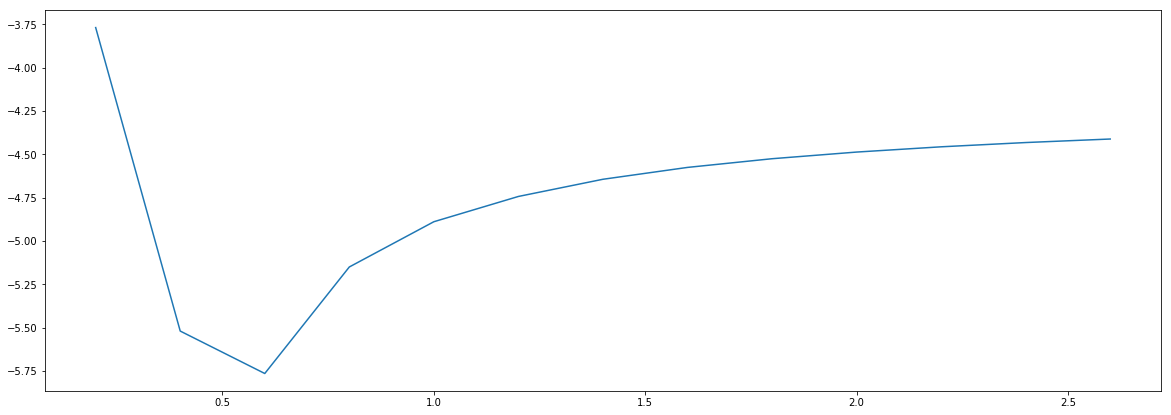

In [36]:
f, t = 16, -1
plt.plot(parameters_values['p1'][f:t], loss_values[f:t])

In [35]:
plt.xticks(np.arange(min(parameters_values['p2']),  np.max(parameters_values['p2']), ) )
plt.imshow(np.log(loss_values))

KeyError: 'p2'

In [ ]:
plt.imshow(errors)

In [ ]:
plt.imshow(errors[:40:50])

In [ ]:
np.argmin(errors[1][:80])

In [ ]:
plt.plot(inits)

In [ ]:
sum(np.array(inits)>0)

In [ ]:
s, e = 0, -1
plot_shared_scale([
    (hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")
])

In [ ]:
s, e = 2, -1
plot_shared_scale([
    (hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test"),
#                   (hist['aux']['train_loss'][s:e], "aux_train"),
#                   (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
#                   (hist['aux']['eval_test'][s:e], "aux_Eval_test")
])

In [ ]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['aux']['train_loss'][s:e], "aux_train"),
                  (hist['aux']['eval_train'][s:e], "aux_Eval_train"),
                  (hist['aux']['eval_test'][s:e], "aux_Eval_test")])

In [ ]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['const']['train_loss'][s:e], "const_aux_train"),
                  (hist['const']['eval_train'][s:e], "const_aux_Eval_train"),
                  (hist['const']['eval_test'][s:e], "const_aux_Eval_test")])

In [ ]:
s, e = 0, -1
plot_shared_scale([
#     (hist['train_loss'][s:e],"Train" ),
#              (hist['eval_train'][s:e], "Eval_train"),
#              (hist['eval_test'][s:e], "Eval_test"),
                  (hist['preds']['1'][s:e], "p1"),
                  (hist['preds']['2'][s:e], "p2"),
#                   (hist['const']['eval_test'][s:e], "const_aux_Eval_test")
])

In [ ]:
model.buffers

In [ ]:
logging.info("Training process END")

In [ ]:
#

In [ ]:
plt.imshow(errors)

In [ ]:
plt.imshow(errors[:, 50:])